In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras




# gestion des dataset

## NSL-KDD

In [2]:
directory = "NSL-KDD/"
train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"
train_path = os.path.join(directory, train_file)


In [31]:

# Load the dataset
df = pd.read_csv(train_path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## NF-UQ-NIDS

### Load an visualize data

In [3]:
directory = "datasets/"
dataset_file = "NF-UQ-NIDS.csv"
dataset_path = os.path.join(directory, dataset_file)

In [4]:
# load the dataset
df = pd.read_csv(dataset_path)

In [6]:
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,Dataset
0,149.171.126.0,62073,59.166.0.5,56082,6,0.0,9672,416,11,8,25,15,0,Benign,NF-UNSW-NB15
1,149.171.126.2,32284,59.166.0.5,1526,6,0.0,1776,104,6,2,25,0,0,Benign,NF-UNSW-NB15
2,149.171.126.0,21,59.166.0.1,21971,6,1.0,1842,1236,26,22,25,1111,0,Benign,NF-UNSW-NB15
3,59.166.0.1,23800,149.171.126.0,46893,6,0.0,528,8824,10,12,27,124,0,Benign,NF-UNSW-NB15
4,59.166.0.5,63062,149.171.126.2,21,6,1.0,1786,2340,32,34,25,1459,0,Benign,NF-UNSW-NB15


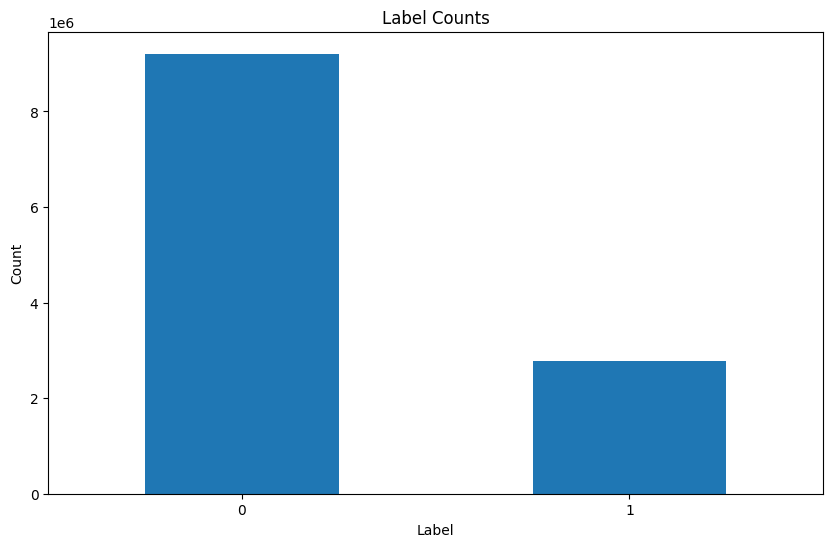

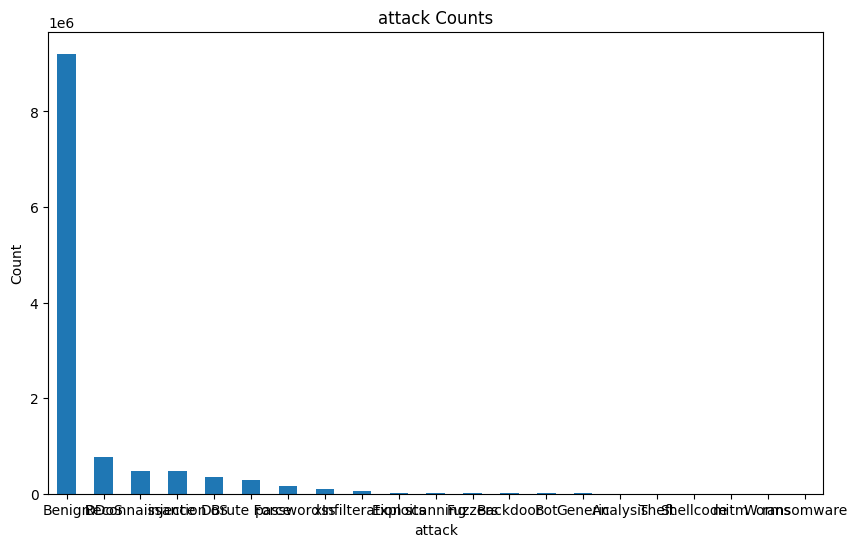

In [5]:
# visualize the dataset columns Label and attack
df['Label'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Counts")
plt.show()

df['Attack'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.xlabel("attack")
plt.ylabel("Count")
plt.title("attack Counts")
plt.show()



In [6]:
# train test split and keep ratio of each Attack class


train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Attack'])

### preprocessing data

In [53]:
# preprocess the data

# encore the categorical features


# create a copy of the train and test data
df_enc = df.copy()
features_names = "IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,Dataset"
# create an object of the LabelEncoder
list_of_le = {}
# apply the LabelEncoder on the categorical features
for feature in features_names.split(","):
    le = LabelEncoder()
    df_enc[feature] = le.fit_transform(df_enc[feature])
    list_of_le[feature] = le



    
    


In [54]:
train_enc, test_enc = train_test_split(df_enc, test_size=0.2, random_state=42, stratify=df_enc['Attack'])

In [9]:
# drop  column dataset
train_enc = train_enc.drop(['Dataset'], axis=1)
test_enc = test_enc.drop(['Dataset'], axis=1)

In [55]:
# only keep 10% of each class in a df copy 
df_10 = df.copy()
df_10 = df_10.groupby('Attack').apply(lambda x: x.sample(frac=0.1))
df_10 = df_10.reset_index(drop=True)

# encode the categorical features
df_10_enc = df_10.copy()

features_names = "IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,Dataset"
# create an object of the LabelEncoder
list_of_le_10 = {}
# apply the LabelEncoder on the categorical features
for feature in features_names.split(","):
    le = LabelEncoder()
    df_10_enc[feature] = le.fit_transform(df_10_enc[feature])
    list_of_le_10[feature] = le




In [67]:
# train test split and keep ratio of each Attack class
train_10_enc, test_10_enc = train_test_split(df_10_enc, test_size=0.96, random_state=42, stratify=df_10_enc['Attack'])

In [68]:
# XGBoost

xgb_clf_10 = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42)

xgb_clf_10.fit(train_10_enc.drop(['Attack','Label'], axis=1), train_10_enc['Attack'])






ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], got [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20]

In [66]:
xgb_clf_10.score(test_10_enc.drop(['Attack','Label'], axis=1), test_10_enc['Attack'])

0.9503192583517914

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 [Text(0, 0.5, 'Analysis'),
  Text(0, 1.5, 'Backdoor'),
  Text(0, 2.5, 'Benign'),
  Text(0, 3.5, 'Bot'),
  Text(0, 4.5, 'Brute Force'),
  Text(0, 5.5, 'DDoS'),
  Text(0, 6.5, 'DoS'),
  Text(0, 7.5, 'Exploits'),
  Text(0, 8.5, 'Fuzzers'),
  Text(0, 9.5, 'Generic'),
  Text(0, 10.5, 'Infilteration'),
  Text(0, 11.5, 'Reconnaissance'),
  Text(0, 12.5, 'Shellcode'),
  Text(0, 13.5, 'Theft'),
  Text(0, 14.5, 'Worms'),
  Text(0, 15.5, 'injection'),
  Text(0, 16.5, 'mitm'),
  Text(0, 17.5, 'password'),
  Text(0, 18.5, 'ransomware'),
  Text(0, 19.5, 'scanning'),
  Text(0, 20.5, 'xss')])

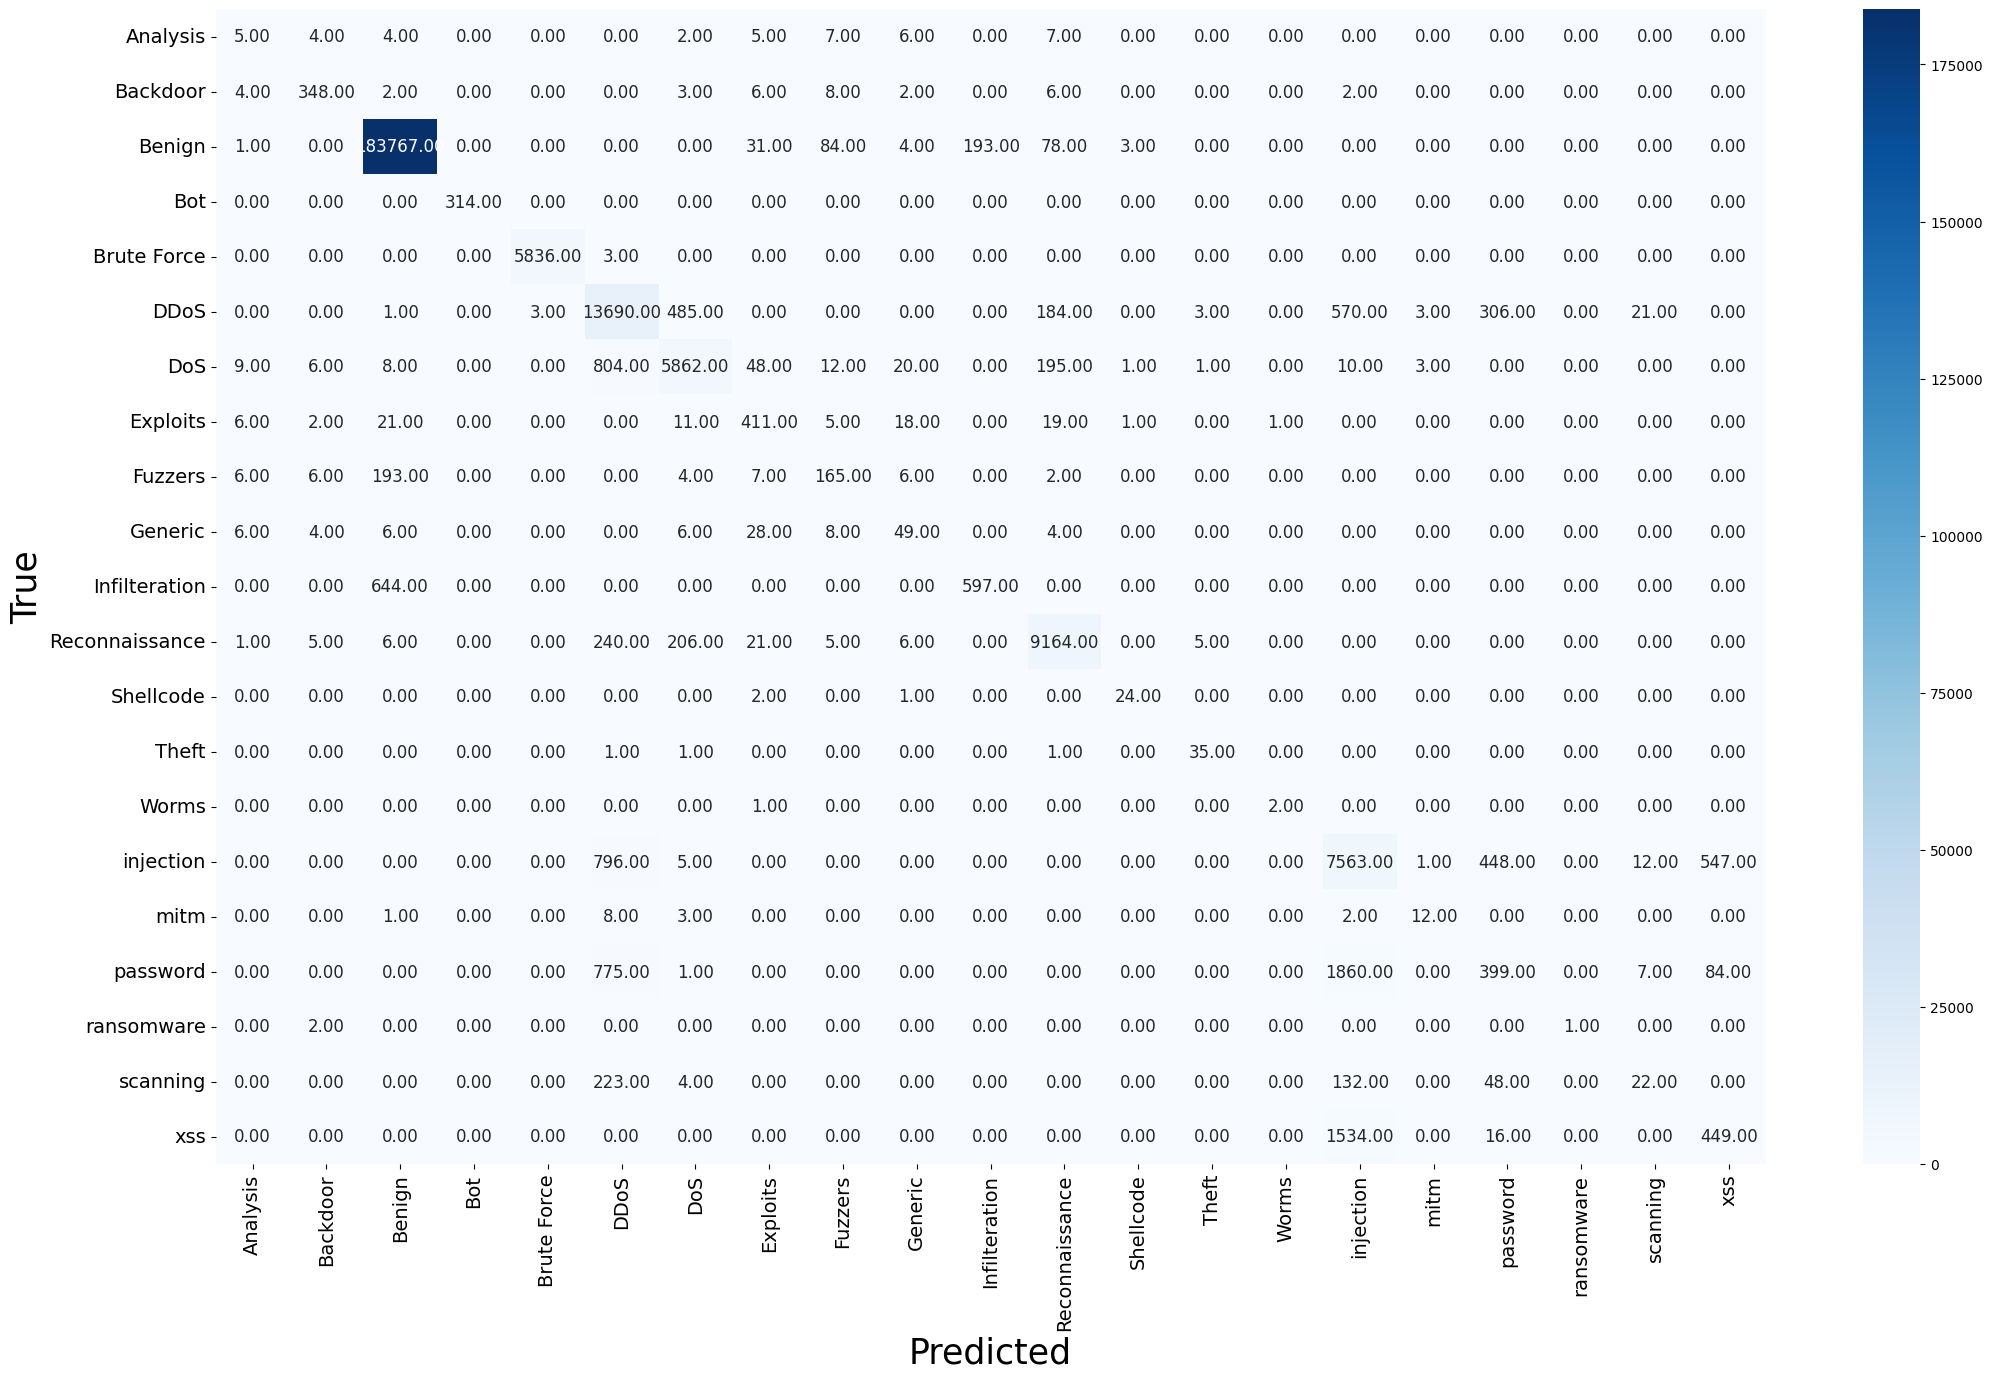

In [52]:
# plot confusion matrix with original labels
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(test_10_enc['Attack'], xgb_clf_10.predict(test_10_enc.drop(['Attack','Label'], axis=1)))
plt.figure(figsize=(25, 15))
# plot seaboern with original labels
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=list_of_le_10['Attack'].classes_, yticklabels=list_of_le_10['Attack'].classes_, annot_kws={"size": 12}, cmap='Blues')

plt.xlabel('Predicted',fontsize=25)
# increase size of x label

plt.ylabel('True',fontsize=25)

#increase font size of labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [19]:
# import classification report
from sklearn.metrics import classification_report


def plot_classification_report(model, X_test, y_test, target_names,name,deep_learning=False):
    """
    Plots the classification report heatmap for a given model's predictions on test data.
    
    Args:
    model : A trained TensorFlow model
    X_test : Test data
    y_test : Ground truth labels for test data
    target_names : Names of the classes
    
    Returns:
    A heatmap plot of the classification report.
    """
    
    # Get the model's predictions on the test data
    y_pred = model.predict(X_test)

    if deep_learning:
        # If the model is a deep learning model, round the predictions to 0 or 1
        y_pred_classes = np.argmax(y_pred, axis=1)
        # Calculate the classification report
        report = classification_report(y_test, y_pred_classes, target_names=target_names, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)
    else:
        # Calculate the classification report
        report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)


    #title
    plt.title(f'Classification Report for {name}')

    
    # Plot the heatmap
    sns.heatmap(report_df.drop(['support'], axis=1).astype(float), annot=True, cmap='coolwarm')
    plt.show()

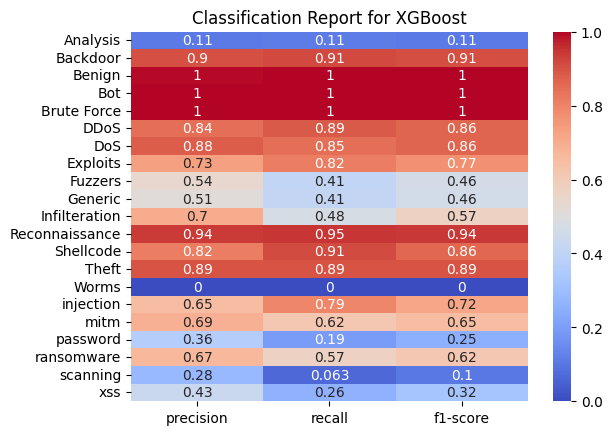

In [43]:
plot_classification_report(xgb_clf_10, test_10_enc.drop(['Attack','Label'], axis=1), test_10_enc['Attack'], list_of_le_10['Attack'].classes_, 'XGBoost')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

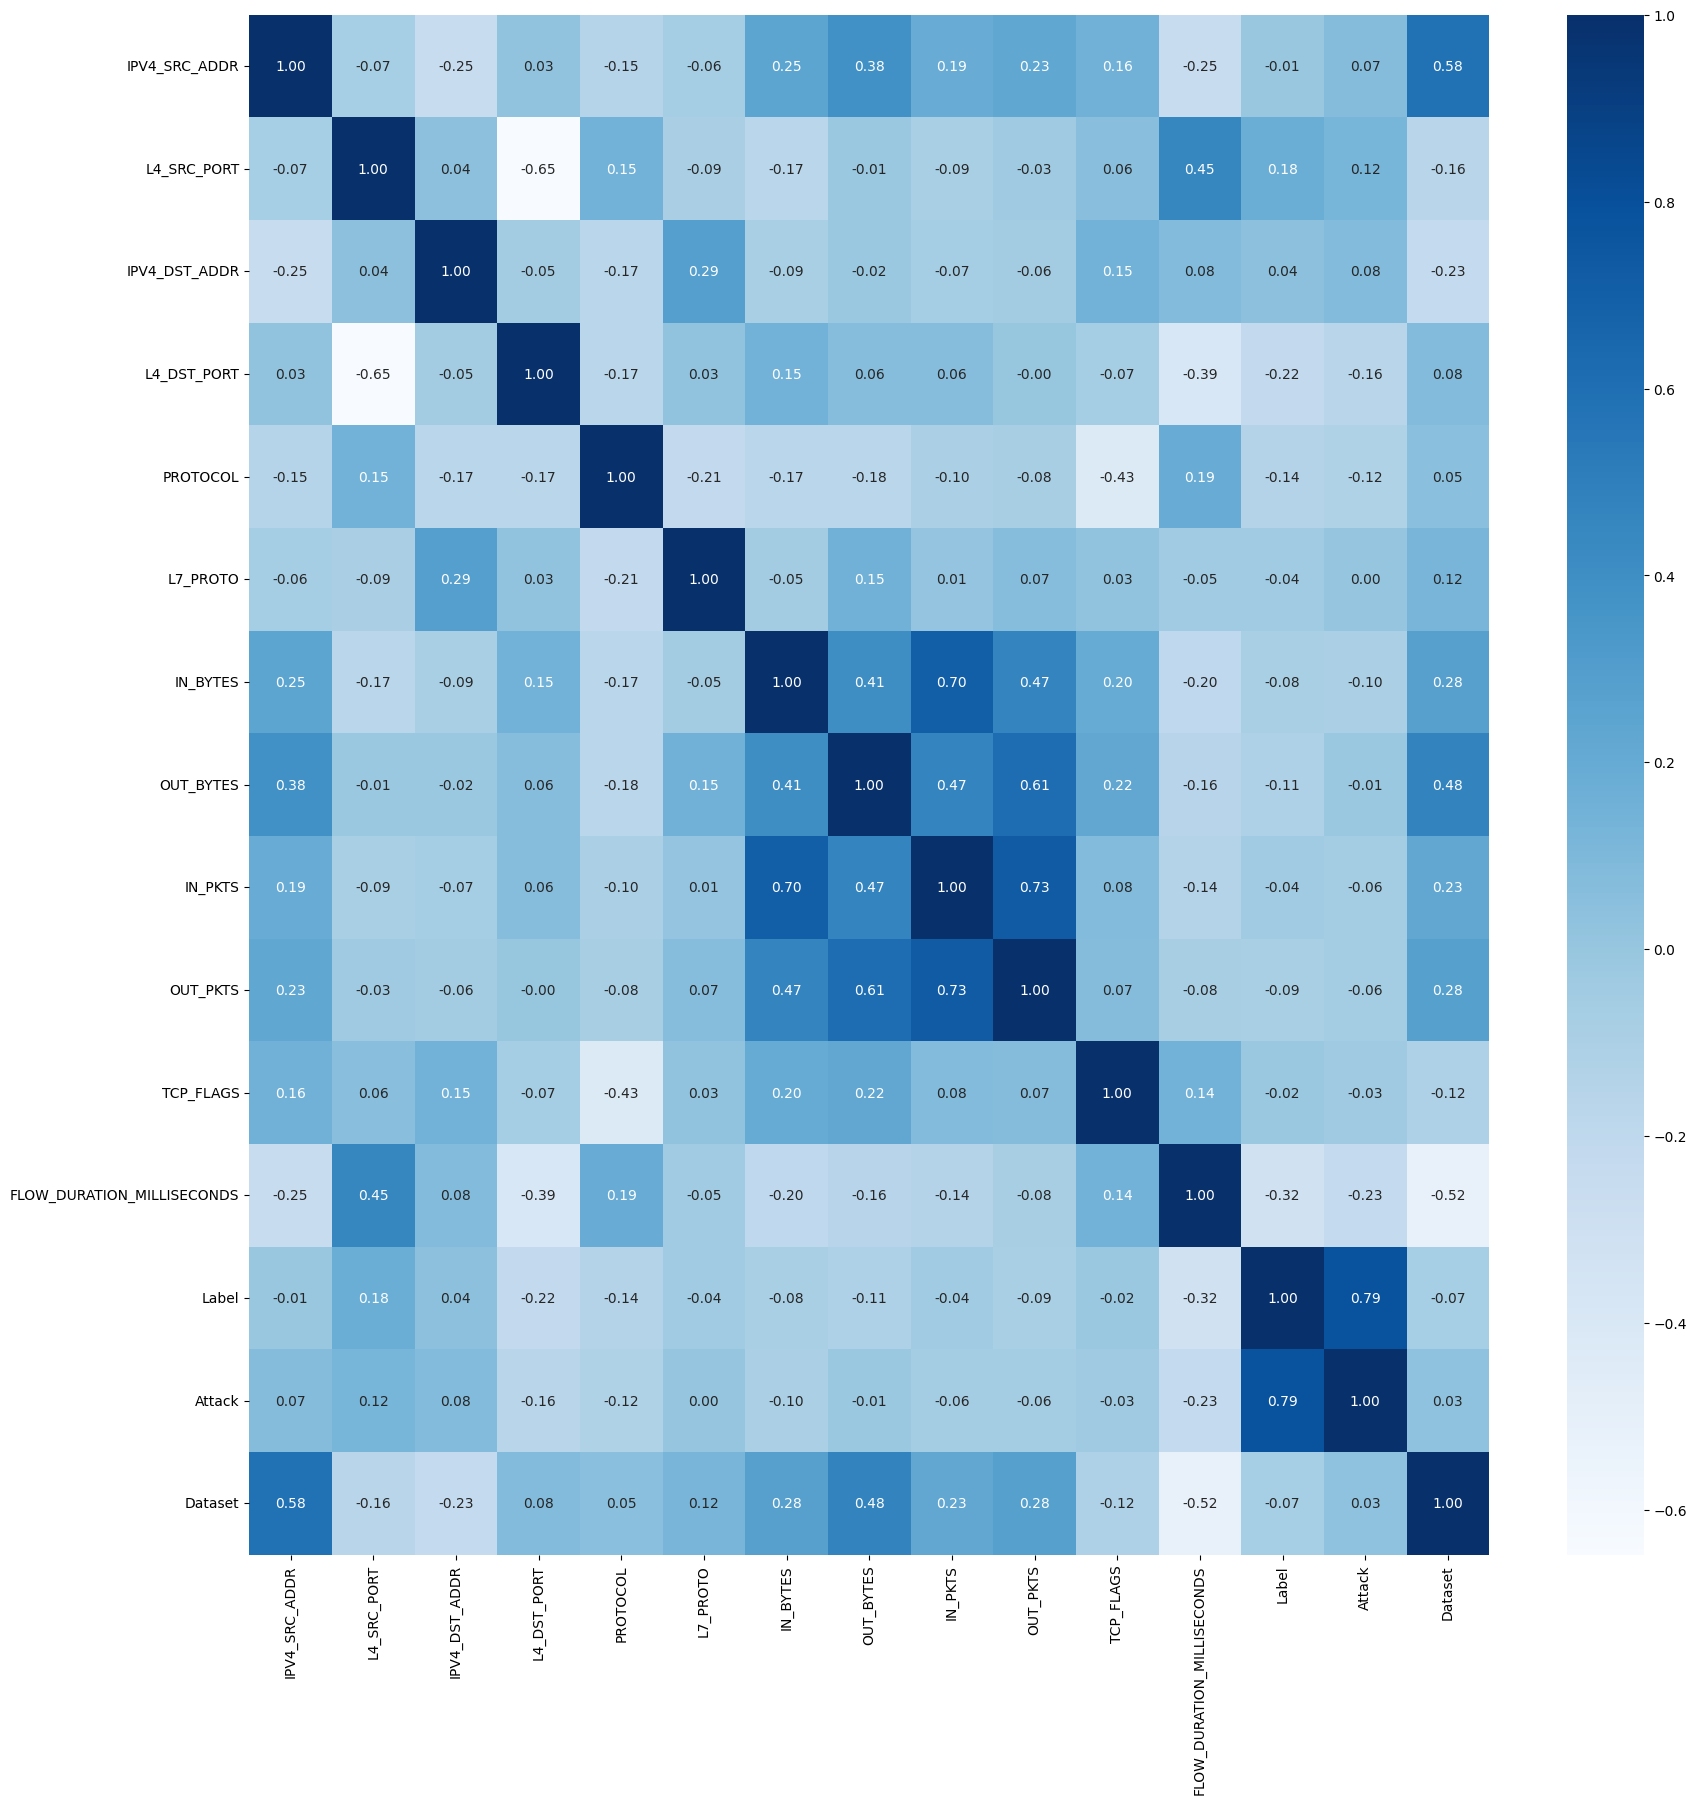

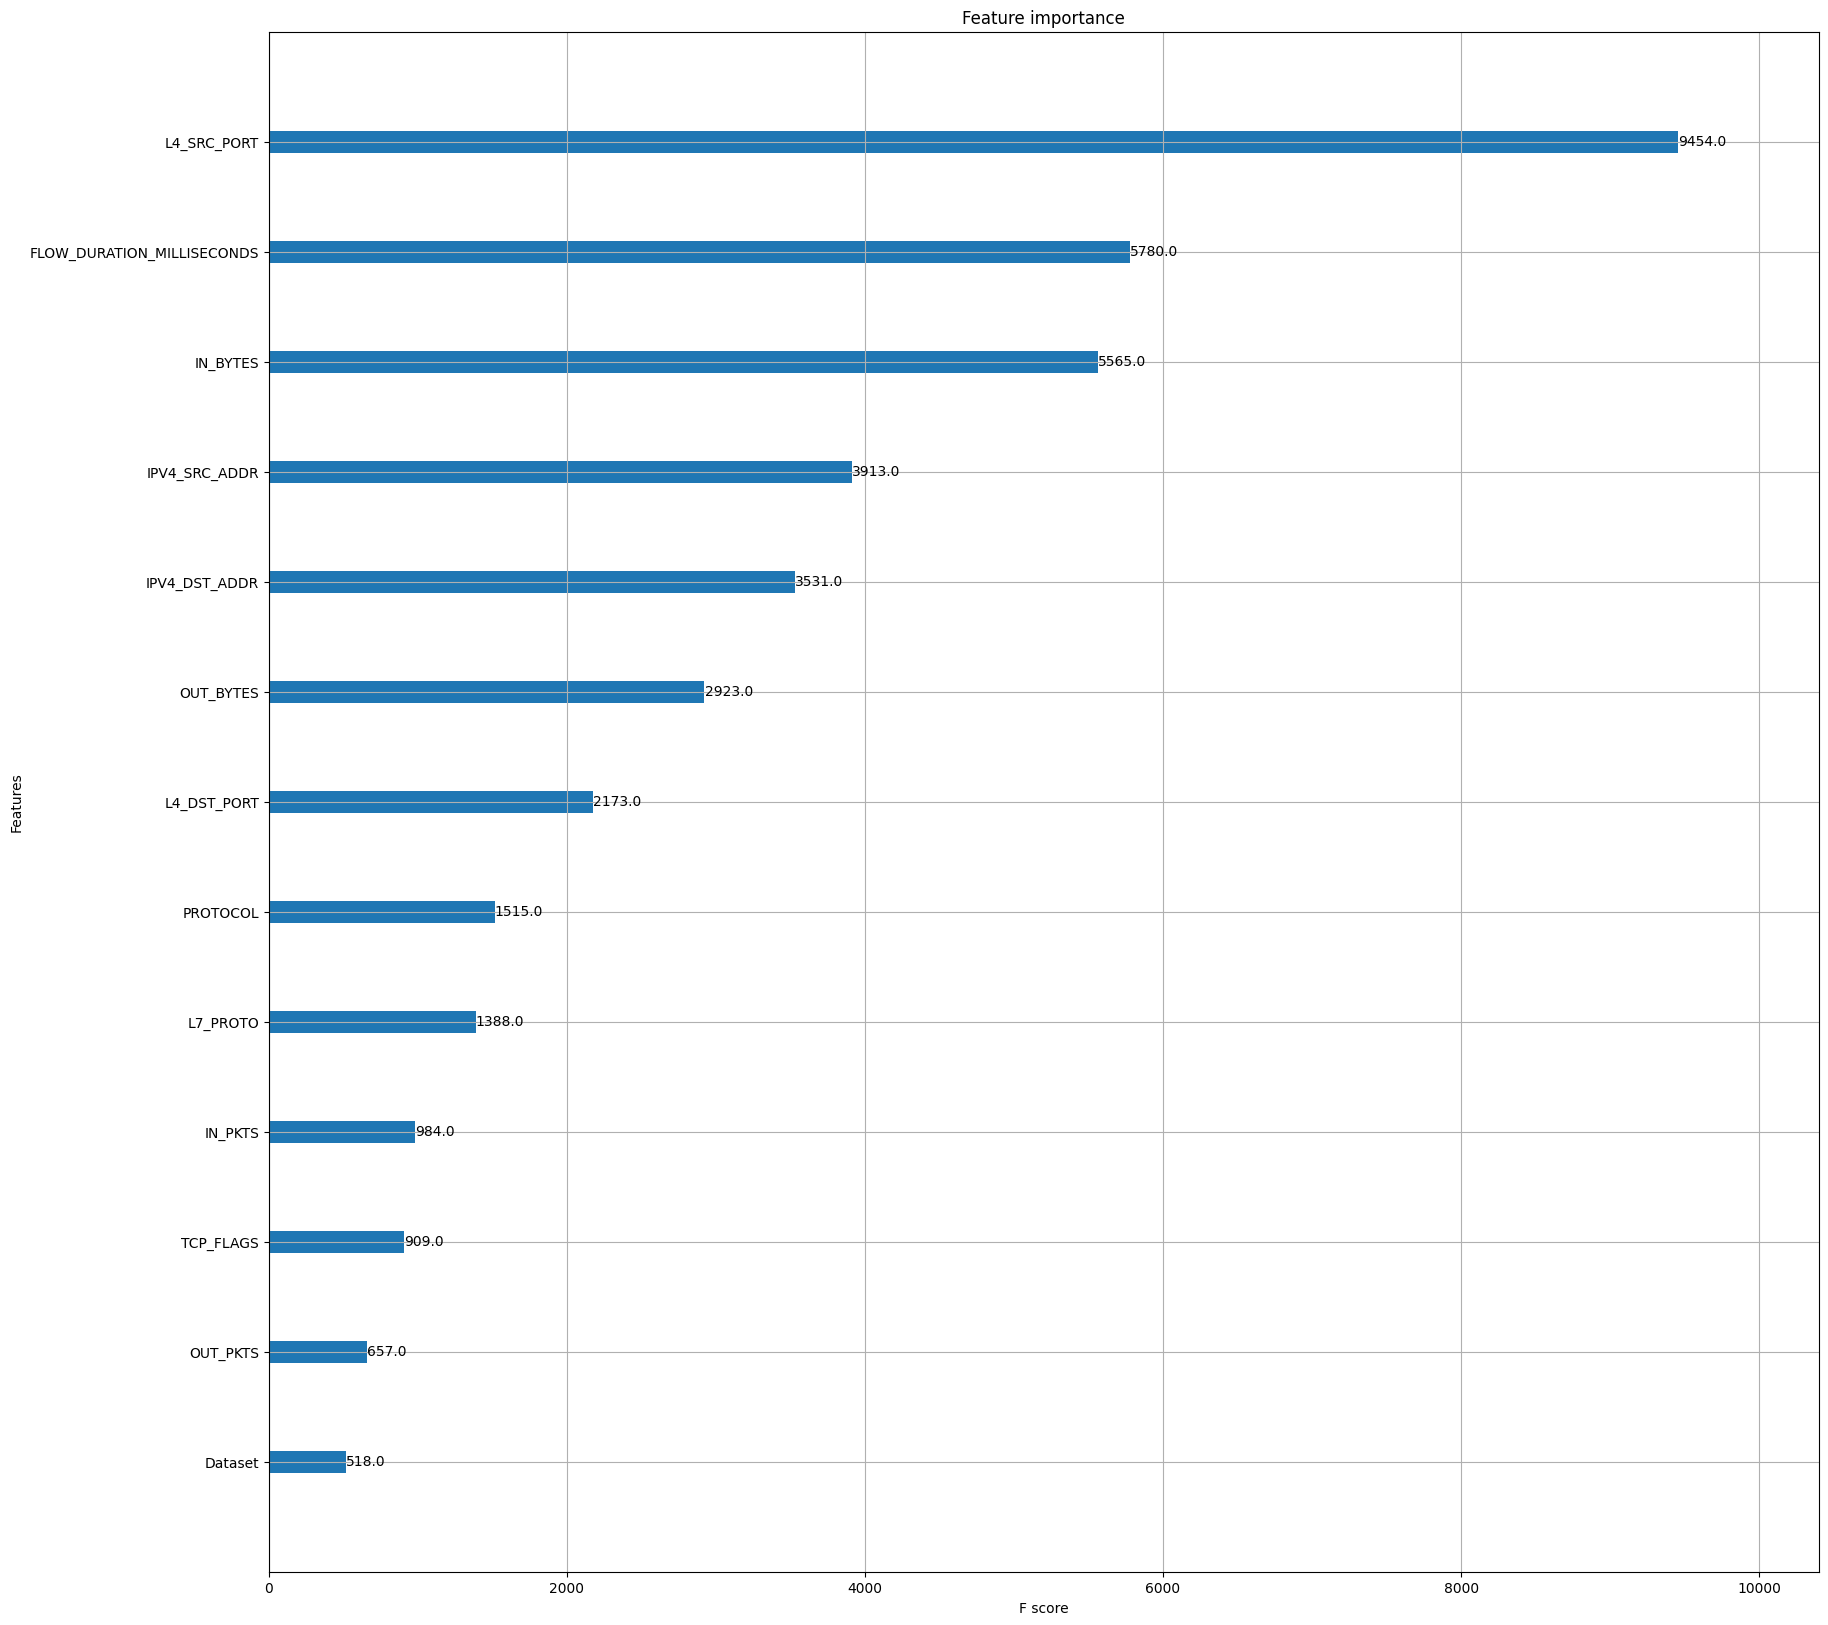

In [62]:
# plot corelation matrix
corr = df_10_enc.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')

# plot feature importance
plt.figure(figsize=(20, 20))
xgb.plot_importance(xgb_clf_10, ax=plt.gca())




In [11]:


# create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, seed=42,verbosity=1, n_jobs=-1)

# fit the classifier to the training data witj njobs=-1
xgb_clf.fit(train_enc.drop(['Attack', 'Label'], axis=1), train_enc['Attack'], early_stopping_rounds=10,
            eval_metric='aucpr', eval_set=[(test_enc.drop(['Attack', 'Label'], axis=1), test_enc['Attack'])])



c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.60517
[1]	validation_0-aucpr:0.65371
[2]	validation_0-aucpr:0.67948
[3]	validation_0-aucpr:0.68394
[4]	validation_0-aucpr:0.69646
[5]	validation_0-aucpr:0.70392
[6]	validation_0-aucpr:0.70753
[7]	validation_0-aucpr:0.71543
[8]	validation_0-aucpr:0.71930
[9]	validation_0-aucpr:0.72334
[10]	validation_0-aucpr:0.72586
[11]	validation_0-aucpr:0.72713
[12]	validation_0-aucpr:0.72830
[13]	validation_0-aucpr:0.72683
[14]	validation_0-aucpr:0.72874
[15]	validation_0-aucpr:0.73425
[16]	validation_0-aucpr:0.73524
[17]	validation_0-aucpr:0.73791
[18]	validation_0-aucpr:0.73826
[19]	validation_0-aucpr:0.73987
[20]	validation_0-aucpr:0.74121
[21]	validation_0-aucpr:0.74255
[22]	validation_0-aucpr:0.74388
[23]	validation_0-aucpr:0.74405
[24]	validation_0-aucpr:0.74601
[25]	validation_0-aucpr:0.74871
[26]	validation_0-aucpr:0.75230
[27]	validation_0-aucpr:0.75318
[28]	validation_0-aucpr:0.75409
[29]	validation_0-aucpr:0.75292
[30]	validation_0-aucpr:0.75496
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [17]:
xgb_clf.save_model('xgb_model.json')



In [13]:
# evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# predict on the test data
y_pred = xgb_clf.predict(test_enc.drop(['Attack', 'Label'], axis=1))

# calculate the accuracy and print it
accuracy = accuracy_score(test_enc['Attack'], y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))





Accuracy: 95.46%


In [19]:
labels = le.labels_


AttributeError: 'LabelEncoder' object has no attribute 'labels_'

In [22]:
le.classes_

array(['NF-BoT-IoT', 'NF-CSE-CIC-IDS2018', 'NF-ToN-IoT', 'NF-UNSW-NB15'],
      dtype=object)

# Deep learning

In [12]:
def format_data_time_step(data, time_step):
    """
    Format time-series data into a format suitable for training a recurrent neural network.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the time-series data. The DataFrame should contain a 'label' column
        and one or more feature columns.

    time_step : int
        The number of time steps (i.e., rows) to include in each sample.

    Returns
    -------
    tuple
        A tuple containing the following six elements in the order given:

        train_data : numpy.ndarray
            An array of shape (n_samples_train, time_step, n_features) containing the training data.

        train_labels : numpy.ndarray
            An array of shape (n_samples_train,) containing the training labels.

        val_data : numpy.ndarray
            An array of shape (n_samples_val, time_step, n_features) containing the validation data.

        val_labels : numpy.ndarray
            An array of shape (n_samples_val,) containing the validation labels.

        test_data : numpy.ndarray
            An array of shape (n_samples_test, time_step, n_features) containing the test data.

        test_labels : numpy.ndarray
            An array of shape (n_samples_test,) containing the test labels.

    Notes
    -----
    This function splits the data into training, validation, and test sets and reshapes the data into
    samples of length `time_step`. The training set includes the first 70% of the data, the validation
    set includes the next 15%, and the test set includes the final 15%. But this is totally arbitrary so dont realy take in account
    """
    unique_labels = data['Attack'].unique()

    train_df = pd.DataFrame(columns=data.columns)
    val_df = pd.DataFrame(columns=data.columns)
    test_df = pd.DataFrame(columns=data.columns)

    for label in unique_labels:
        label_df = data[data['Attack'] == label]
        train_samples = label_df.iloc[:int(len(label_df) * 0.60)]
        test_samples = label_df.iloc[int(len(label_df) * 0.60):int(len(label_df) * 0.75)]
        val_samples = label_df.iloc[int(len(label_df) * 0.75):]

        train_df = train_df.append(train_samples)
        val_df = val_df.append(val_samples)
        test_df = test_df.append(test_samples)

    #train df 

    # Define a function to reshape the input data into the required format for LSTM models
    def reshape_data(data):
        data_list = []
        for i in range(len(data) - time_step + 1):
            data_list.append(data[i:i+time_step, :])
        return np.array(data_list)

    # Reshape the training data and extract the labels
    train_data = reshape_data(train_df.drop(['Attack'], axis=1).to_numpy())
    train_labels = train_df['Attack'].iloc[time_step-1:].to_numpy()

    # Reshape the validation data and extract the labels
    val_data = reshape_data(val_df.drop(['Attack'], axis=1).to_numpy())
    val_labels = val_df['Attack'].iloc[time_step-1:].to_numpy()

    # Reshape the test data and extract the labels
    test_data = reshape_data(test_df.drop(['Attack'], axis=1).to_numpy())
    test_labels = test_df['Attack'].iloc[time_step-1:].to_numpy()

    train_data = train_data.astype('float32')
    train_labels = train_labels.astype('float32')
    val_data = val_data.astype('float32')
    val_labels = val_labels.astype('float32')
    test_data = test_data.astype('float32')
    test_labels = test_labels.astype('float32')
    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [13]:
train_deep_data, train_deep_labels, val_deep_data, val_deep_labels, test_deep_data, test_deep_labels = format_data_time_step(df_10_enc, 10)

C:\Users\enzoh\AppData\Local\Temp\ipykernel_30144\3320629989.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_samples)
C:\Users\enzoh\AppData\Local\Temp\ipykernel_30144\3320629989.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_df = val_df.append(val_samples)
C:\Users\enzoh\AppData\Local\Temp\ipykernel_30144\3320629989.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_samples)
C:\Users\enzoh\AppData\Local\Temp\ipykernel_30144\3320629989.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_samples)
C:\Users\enzoh\AppData\Local\

In [14]:
input_shape = (train_deep_data.shape[1],train_deep_data.shape[2])
num_labels = len(np.unique(train_deep_labels))

## Simple Lstm

# model

In [15]:
# create the model
simple_lstm_model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=input_shape),
    keras.layers.Dense(num_labels, activation='softmax')
])

simple_lstm_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               73216     
                                                                 
 dense (Dense)               (None, 21)                2709      
                                                                 
Total params: 75,925
Trainable params: 75,925
Non-trainable params: 0
_________________________________________________________________


### Fit and test

In [17]:
history_simple_lstm = simple_lstm_model.fit(train_deep_data, train_deep_labels, epochs=10, batch_size=512,validation_data=(val_deep_data, val_deep_labels))

Epoch 1/10
1406/1406 [==============================] - 9s 6ms/step - loss: 0.1199 - accuracy: 0.9633 - val_loss: 0.1103 - val_accuracy: 0.9662
Epoch 2/10
1406/1406 [==============================] - 8s 6ms/step - loss: 0.0915 - accuracy: 0.9716 - val_loss: 0.0874 - val_accuracy: 0.9718
Epoch 3/10
1406/1406 [==============================] - 8s 6ms/step - loss: 0.0821 - accuracy: 0.9725 - val_loss: 0.0723 - val_accuracy: 0.9748
Epoch 4/10
1406/1406 [==============================] - 9s 7ms/step - loss: 0.0715 - accuracy: 0.9748 - val_loss: 0.0637 - val_accuracy: 0.9763
Epoch 5/10
1406/1406 [==============================] - 9s 7ms/step - loss: 0.0743 - accuracy: 0.9730 - val_loss: 0.0752 - val_accuracy: 0.9728
Epoch 6/10
1406/1406 [==============================] - 9s 6ms/step - loss: 0.0753 - accuracy: 0.9728 - val_loss: 0.0755 - val_accuracy: 0.9726
Epoch 7/10
1406/1406 [==============================] - 9s 6ms/step - loss: 0.0667 - accuracy: 0.9755 - val_loss: 0.0613 - val_accuracy:

In [18]:
simple_lstm_model.evaluate(test_deep_data, test_deep_labels, verbose=2)

5623/5623 - 17s - loss: 0.0677 - accuracy: 0.9743 - 17s/epoch - 3ms/step


[0.06769952923059464, 0.9743379950523376]

5623/5623 [==============================] - 12s 2ms/step


c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

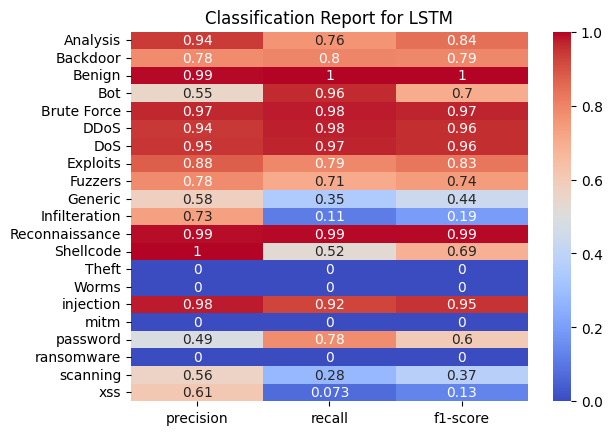

In [27]:
plot_classification_report(simple_lstm_model,test_deep_data,test_deep_labels,list_of_le_10['Attack'].classes_,"LSTM",deep_learning=True)

## CNN

### Modèle 

In [38]:
model_cnn = keras.Sequential([
    keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling1D(pool_size=2),
    # dropout layer
    # keras.layers.Dropout(0.5),
    keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    # dropout layer
    # keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation='relu'),
    # dropout layer
    keras.layers.Dense(num_labels, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [39]:
history_cnn = model_cnn.fit(train_deep_data, train_deep_labels, epochs=10, batch_size=512,validation_data=(val_deep_data, val_deep_labels))

Epoch 1/10
1406/1406 [==============================] - 8s 5ms/step - loss: 32.1463 - accuracy: 0.9559 - val_loss: 3.7481 - val_accuracy: 0.9766
Epoch 2/10
1406/1406 [==============================] - 6s 5ms/step - loss: 1.9261 - accuracy: 0.9761 - val_loss: 1.3267 - val_accuracy: 0.9802
Epoch 3/10
1406/1406 [==============================] - 6s 4ms/step - loss: 0.8609 - accuracy: 0.9794 - val_loss: 0.7647 - val_accuracy: 0.9792
Epoch 4/10
1406/1406 [==============================] - 7s 5ms/step - loss: 0.4436 - accuracy: 0.9799 - val_loss: 0.8307 - val_accuracy: 0.9758
Epoch 5/10
1406/1406 [==============================] - 16s 11ms/step - loss: 0.2651 - accuracy: 0.9808 - val_loss: 0.3174 - val_accuracy: 0.9790
Epoch 6/10
1406/1406 [==============================] - 16s 12ms/step - loss: 0.1621 - accuracy: 0.9810 - val_loss: 0.3090 - val_accuracy: 0.9802
Epoch 7/10
1406/1406 [==============================] - 16s 12ms/step - loss: 0.1136 - accuracy: 0.9820 - val_loss: 0.1681 - val_ac

5623/5623 [==============================] - 9s 2ms/step


c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

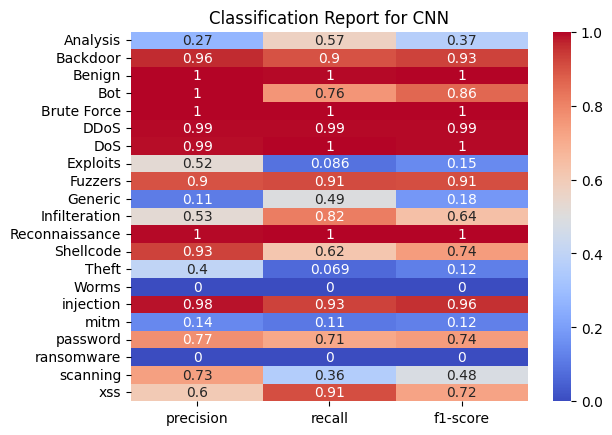

In [31]:
plot_classification_report(model_cnn,test_deep_data,test_deep_labels,list_of_le_10['Attack'].classes_,"CNN",deep_learning=True)

In [ ]:
# plot confusion matrix
